<img src="../../docs/images/dlsia.png" width=600 />

# Image classification with Randomized Sparse Mixed Scale Autoencoders, regularized by the availability of image labels

Authors: Eric Roberts and Petrus Zwart

E-mail: PHZwart@lbl.gov, EJRoberts@lbl.gov
___

This notebook highlights some basic functionality with the dlsia package.

In this notebook we setup autoencoders, with the goal to explore the latent space it generates. In this case however, we will guide the formation of the latent space by including labels to specific images.

The autoencoders we use are based on randomly construct convolutional neural networks in which we can control the number of parameters it contains. This type of control can be beneficial when the amount of data on which one can train a network is not very voluminous, as it allows for better handles on overfitting.

The constructed latent space can be used for unsupervised and supervised exploration methods. In our limited experience, the classifiers that are trained come out of the data are reasonable, but can be improved upon using classic classification methods, as shown further.
___

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from dlsia.core import helpers
from dlsia.core import train_scripts
from dlsia.core.networks import baggins
from dlsia.core.networks import sparsenet
from dlsia.test_data.two_d import random_shapes
from dlsia.core.utils import latent_space_viewer
from dlsia.viz_tools import plots
from dlsia.viz_tools import plot_autoencoder_image_classification as paic



import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import DataLoader, TensorDataset
import einops
import umap

## Create data

Using our dlsia in-house data generator, we produce a number of noisy "shapes" images consisting of single triangles, rectangles, circles, and donuts/annuli, each assigned a different class. In addition to augmenting with random orientations and sizes, each raw, ground truth image will be bundled with its corresponding noisy and binary mask.

#### Parameters to toggle:
- n_train : number of ground truth/noisy/label image bundles to generate for training
- n_labeled : number of images with labels
- n_test : number of ground truth/noisy/label image bundles to generate for testing
- noise_level :  per-pixel noise drawn from a continuous uniform distribution (cut-off above at 1)
- nxy : size of individual images

In [4]:
n_train = 400
n_labeled = 200

n_test  = 400
noise_level = 0.50
nxy = 32

train_data = random_shapes.build_random_shape_set_numpy(n_imgs=n_train,
                                                        noise_level=noise_level,
                                                        n_xy=nxy)
test_data = random_shapes.build_random_shape_set_numpy(n_imgs=n_test,
                                                       noise_level=noise_level,
                                                       n_xy=nxy)


## View shapes data

In [ ]:
plots.plot_shapes_data_numpy(train_data)

### Dataloader class

Here we cast all images from numpy arrays and the PyTorch Dataloader class for easy handling and iterative loading of data into the networks and models. 

Once again, to reduce/increase memory consumption, tune the batch_size parameter.

In [7]:
which_one = "Noisy" #"GroundTruth" 

batch_size = 100

loader_params = {'batch_size': batch_size, 
                 'shuffle': True} 
train_imgs = torch.Tensor(train_data[which_one]).unsqueeze(1)
train_labels = torch.Tensor(train_data["Label"]).unsqueeze(1)-1
train_labels[n_labeled:]=-1 # remove some labels to highlight 'mixed' training

Ttrain_data = TensorDataset(train_imgs,train_labels)
train_loader = DataLoader(Ttrain_data, **loader_params)

loader_params = {'batch_size': batch_size, 
                 'shuffle': False} 
test_images = torch.Tensor(test_data[which_one]).unsqueeze(1)
test_labels = torch.Tensor(test_data["Label"]).unsqueeze(1)-1
Ttest_data = TensorDataset( test_images, test_labels ) 
test_loader = DataLoader(Ttest_data, **loader_params)


## Build SMSNet Autoencoders

Define SMSNet (Sparse Mixed-Scale Network) Autoencoder architecture-governing hyperparameters here. 

### Hyperparameters

There are a number of parameters to play with that impact the size of the random sparse mixed-scale Autoencoder:

- latent_shape: the spatial footprint of the image in latent space. I don't recommend going below 4x4, because it interferes with the  dilation choices. This is a bit of a bug, we need to fix that.
- out_channels: the number of channels of the latent image. Determines the dimension of latent space: (channels,latent_shape[-2], latent_shape[-1])
- depth: the depth of the random sparse convolutional encoder / decoder
- hidden channels: The number of channels put out per convolution. 
- max_degree / min_degree : This determines how many connections you have per node.
    
    
Other parameters do not impact the size of the network dramatically / at all:

- in_shape: determined by the input shape of the image.
- dilations: the maximum dilation should not exceed the smallest image dimension.
- alpha_range: determines the type of graphs (wide vs skinny). When alpha is large,the chances for skinny graphs to be generated increases. We don't know which parameter choice is best, so we randomize it's choice.
- gamma_range: no effect unless the maximum degree and min_degree are far apart. We don't know which parameter choice is best, so we randomize it's choice.
- pIL, pLO, IO: keep as is. 
- stride_base: make sure your latent image size can be generated from the in_shape by repeated division of with this number.

For the classification, specify the number of output classes. Here we work with 4 shapes, so set it to 4.
The dropout rate governs the dropout layers in the classifier part of the networks and doesn't affect the autoencoder part.

### Initialize networks

In [9]:
autoencoders = []
n_models = 7
for ii in range(n_models):
    print('Training network ', ii)
    torch.cuda.empty_cache()
    autoencoder = sparsenet.SparseAEC(in_shape=(32, 32), 
                                      latent_shape=(8, 8), 
                                      out_classes=4,
                                      depth=40, 
                                      dilations=[1,2,3], 
                                      hidden_channels=3, 
                                      out_channels=2, 
                                      alpha_range=(0.0, 0.25), 
                                      gamma_range=(0.0, 0.5), 
                                      max_degree=10, min_degree=10, 
                                      pIL=0.15, 
                                      pLO=0.15, 
                                      IO=False, 
                                      stride_base=2, 
                                      dropout_rate=0.15,)
    autoencoders.append(autoencoder)
    pytorch_total_params = helpers.count_parameters(autoencoder)
    print( "Number of parameters in network", ii , ': ', pytorch_total_params)

Training network  0
Number of parameters in network 0 :  145324
Training network  1
Number of parameters in network 1 :  204689
Training network  2
Number of parameters in network 2 :  203916
Training network  3
Number of parameters in network 3 :  196594
Training network  4
Number of parameters in network 4 :  178282
Training network  5
Number of parameters in network 5 :  269593
Training network  6
Number of parameters in network 6 :  228877


## Train networks

We specify the learning rate and the number of epochs for used for each training instance.

**Note:** we define two optimizers: one for autoencoding and one for classification. They will be minimized in sequence (one after another) instead of building a single sum of targets. This avoids choosing the right weight. 

The mini-epochs are the number of epochs it passes over the whole data set to optimize a single target function. The autoencoder is done first.

In [10]:
num_epochs = 20
learning_rate = 1e-3

for ii in range(n_models):
    autoencoder = autoencoders[ii]
    torch.cuda.empty_cache()

    criterion_AE = nn.MSELoss()
    optimizer_AE = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    criterion_label = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer_label = optim.Adam(autoencoder.parameters(), lr=learning_rate)


    rv = train_scripts.autoencode_and_classify_training(net=autoencoder.to('cuda:0'),
                                                        trainloader=train_loader,
                                                        validationloader=test_loader,
                                                        macro_epochs=num_epochs,
                                                        mini_epochs=3,
                                                        criteria_autoencode=criterion_AE,
                                                        minimizer_autoencode=optimizer_AE,
                                                        criteria_classify=criterion_label,
                                                        minimizer_classify=optimizer_label,
                                                        device="cuda:0", 
                                                        show=10, 
                                                        clip_value=100.0)
    
    print('Autoencoder input reconstruction performance')
    plots.plot_training_results_segmentation(rv[2]).show()
    
    print('Image classification performance')
    plots.plot_training_results_regression(rv[1]).show()


Epoch    4,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 7.6078e-02 | Validation Loss      : 7.6025e-02
Training CC      : 0.7900     | Validation CC        : 0.7865 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 9.2222e-01 | Validation Loss      : 8.8710e-01
Training F1 Macro: 0.6677     | Validation F1 Macro  : 0.7083 
Training F1 Micro: 0.6766     | Validation F1 Micro  : 0.7025 

Epoch    7,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 4.3855e-02 | Validation Loss      : 4.2505e-02
Training CC      : 0.8515     | Validation CC        : 0.8515 
** Classification Losses **
Training Loss    : 5.7237e-01 | Validation Loss      : 6.6970e-01
Training F1 Macro: 0.7635     | Validation F1 Macro  : 0.7748 
Training F1 Micro: 0.7550     | Validation F1 Micro  : 0.7775 

Epoch   10,  of 20 >-*-< Mini Epoch     3 of

Image classification performance


Epoch    4,  of 20 >-*-< Mini Epoch     1 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **
Training Loss    : 6.9182e-02 | Validation Loss      : 6.9431e-02
Training CC      : 0.8040     | Validation CC        : 0.7978 
** Classification Losses **    <---- Now Optimizing
Training Loss    : 8.2768e-01 | Validation Loss      : 8.9613e-01
Training F1 Macro: 0.6823     | Validation F1 Macro  : 0.6561 
Training F1 Micro: 0.7084     | Validation F1 Micro  : 0.6600 

Epoch    7,  of 20 >-*-< Mini Epoch     2 of 3 >-*-< Learning rate 1.000e-03
** Autoencoding Losses **      <---- Now Optimizing
Training Loss    : 4.3305e-02 | Validation Loss      : 4.3146e-02
Training CC      : 0.8536     | Validation CC        : 0.8538 
** Classification Losses **
Training Loss    : 5.5720e-01 | Validation Loss      : 6.9259e-01
Training F1 Macro: 0.7413     | Validation F1 Macro  : 0.7040 
Training F1 Micro: 0.7508     | Validation F1 Micro  : 0.7050 

Epoch   10,  of 20 >-*-< Mini Epoch     3 of

KeyboardInterrupt: 

## Network evaluation

We pass over the test data again with the newly trained networks and collect stuff so we can inspect what is happening.

### Network bagging

In [7]:
bagged_model = baggins.autoencoder_labeling_model_baggin(autoencoders)

In [8]:
import tqdm
results = []
pres = []
sresults = []
spres = []

latent = []
true_lbl = []
inp_img = []
for batch in tqdm.tqdm(test_loader):
    true_lbl.append(batch[1])
    with torch.no_grad():
        inp_img.append(batch[0].cpu())
        res, sres, ps, sps = bagged_model(batch[0], "cuda:0", True)        
        results.append(res.cpu())
        pres.append(ps.cpu())
        sresults.append(sres.cpu())
        spres.append(sps.cpu())
        
results = torch.cat(results, dim=0)
pres = torch.cat(pres,dim=0)
sresults = torch.cat(sresults, dim=0)
spres = torch.cat(spres,dim=0)

true_lbl = torch.cat(true_lbl, dim=0)    
inp_img = torch.cat(inp_img, dim=0)

100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


### Network performance metrics

We evaluate the bagged calssifier performance using  F1 scores.

In [9]:
Macro_F1, Micro_F1 = train_scripts.segmentation_metrics(pres, true_lbl[:,0].type(torch.LongTensor))
print(f"Macro F1 on Test Data {Macro_F1: 6.5f}")
print(f"Micro F1 on Test Data {Micro_F1: 6.5f}")


Macro F1 on Test Data  0.97750
Micro F1 on Test Data  0.97778


### View predictions and confidence

Below we view the network predictions on images previously unseen in the training process. Class probabilities and prediction confidence is shown

--------       The first 10 images encountered     ----------


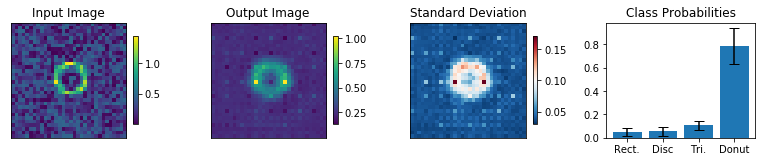

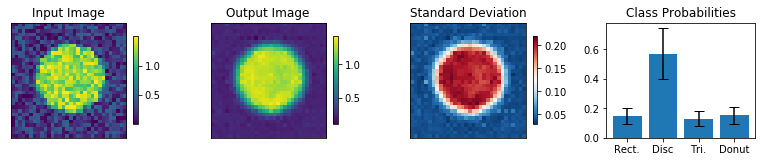

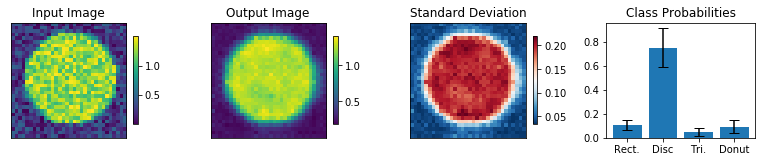

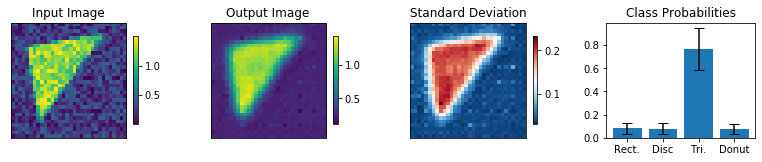

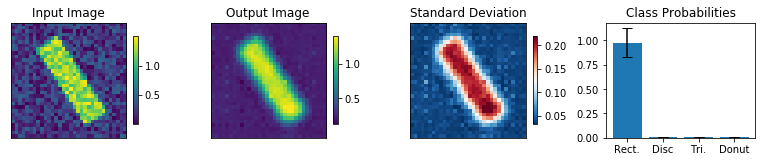

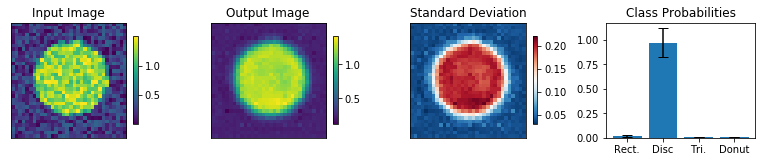

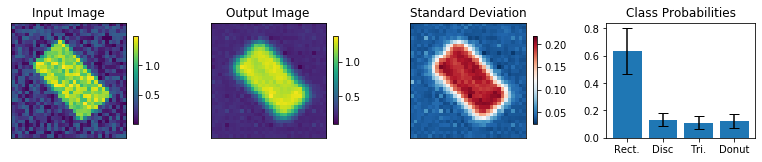

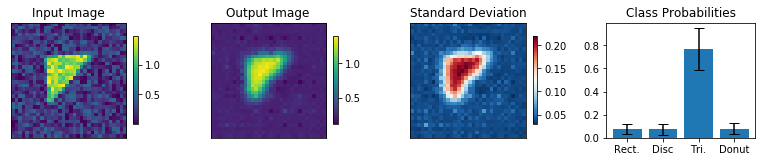

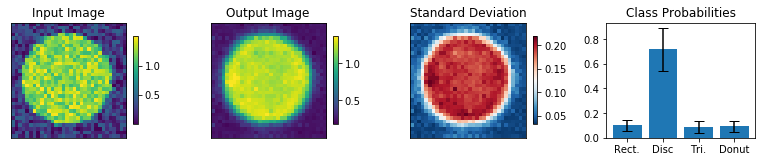

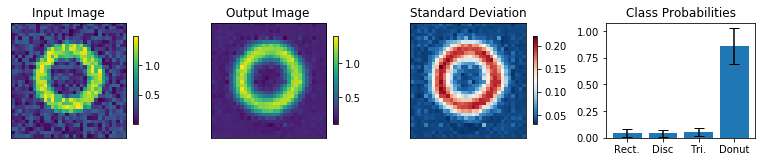

--------       Incorrectly labeled images  (10 max)   ----------


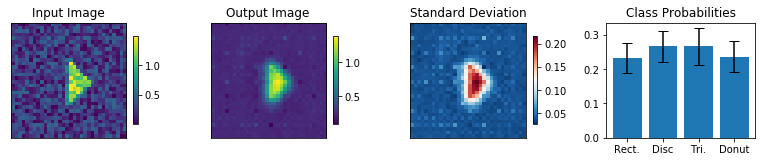

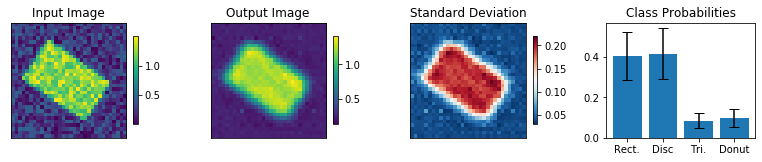

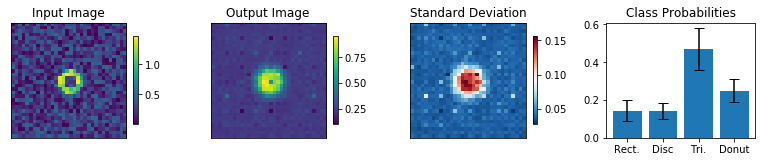

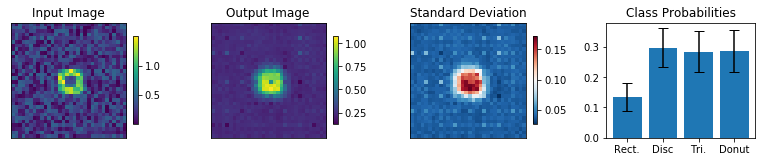

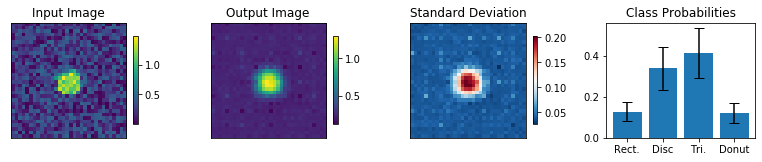

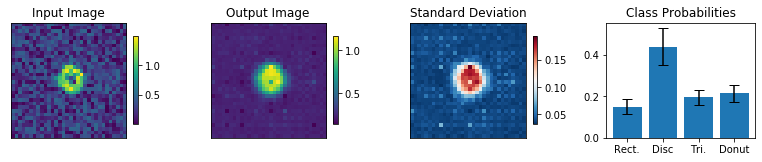

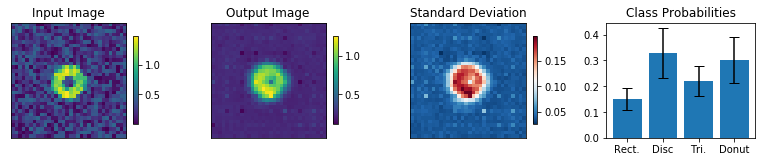

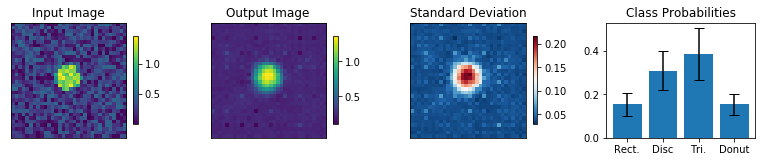

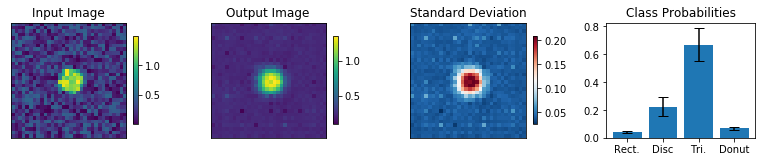

In [11]:
count = 0
print("--------       The first 10 images encountered     ----------")
for img, simg, p, sp, tlbl, ori in zip(results, sresults, pres, spres, true_lbl, inp_img):
    if count < 10:
        fig = paic.plot_autoencoder_and_label_results_with_std(
            input_img=ori[0].numpy(),
            output_img=img[0].numpy(),
            std_img=simg[0].numpy(),
            p_classification=p.numpy(),
            std_p_classification=sp.numpy(),
            class_names=["Rect.","Disc","Tri.","Donut"])
        plt.show()
        count += 1
    

print("--------       Incorrectly labeled images  (10 max)   ----------")
count = 0
for img, simg, p, sp, tlbl, ori in zip(results, sresults, pres, spres, true_lbl, inp_img):
    ilbl = np.argmax(p.numpy())
    if int(tlbl) != int(ilbl):
        fig = paic.plot_autoencoder_and_label_results_with_std(
            input_img=ori[0].numpy(),
            output_img=img[0].numpy(),
            std_img=simg[0].numpy(),
            p_classification=p.numpy(),
            std_p_classification=sp.numpy(),
            class_names=["Rect.","Disc","Tri.","Donut"])
        plt.show()
        count += 1
    if count > 10:
        break


In [13]:
latent = einops.rearrange(latent, "N C Y X -> N (C Y X)")
umapper = umap.UMAP(min_dist=0, n_neighbors=35)
X = umapper.fit_transform(latent.numpy())

TypeError: Rearrange can't be applied to an empty list

In [12]:
count = 0
for img, cc, tlbl, ori, pl in zip(results, pres, true_lbl, inp_img, infered_labels):
    if int(tlbl[0]) != pl-1:        
        paic.plot_autoencoder_and_label_results(input_img=ori.numpy()[0,...], 
                                       output_img=img.numpy()[0,...], 
                                       p_classification=cc.numpy(),
                                       class_names=["Rectangle","Disc","Triangle","Annulus"])
        plt.show()
        count += 1
    if count > 5:
        break

NameError: name 'infered_labels' is not defined